For this project, I will be entering into the Bag of Words Meets Bags of Popcorn competition on Kaggle. The competition's goal is to use Google's Word2Vec deep learning method for text sentiment analysis. I will also be training a supervised learning method and a couple RNN's to test against Word2Vec. The project consists of training and test data that is reviews of movies, and the goal is to accurately predict the sentiment (Favorable or Non-Favorable) of the test reviews. The training data consists of both labeled and unlabeled reviews.

Importing libraries for use in the project

In [87]:
import pandas as pd 
from bs4 import BeautifulSoup 
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt

First thing I will do is train a simple bag of words model, mostly for comparison to the deep learning methods I will implement later. Here I will also clean the training and test data that will be used throughout the project.

In [3]:
# read the labeled training data      
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [5]:
train.shape

(25000, 3)

In [215]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

My labeled training data consists of 25000 entries, with a id, review, and sentiment for each entry.

In [216]:
train['length'] = train['review'].str.len()

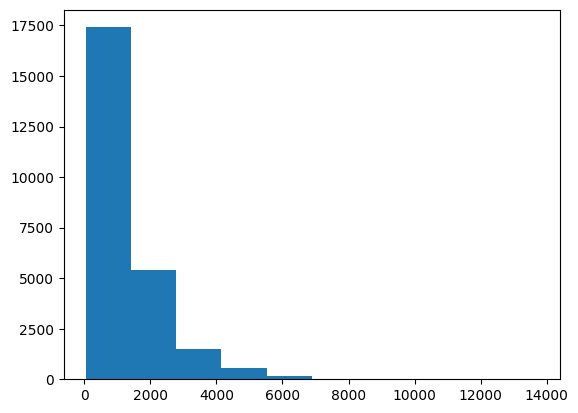

In [217]:
plt.hist(train['length'])
plt.show()

Most reviews are under 2000 letters

In [8]:
print (train["review"][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

Using BeautifulSoup to get rid of HTML, etc.

In [10]:
# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(train["review"][0])  

# Print the raw review and then the output of get_text(), for 
# comparison
print (train["review"][0])
print (example1.get_text())

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

Using re to get rid of everything except letters. Might be worthwhile to leave certain punctuation or numbers in, but for simplicity, just sticking with letter.

In [11]:
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

Splitting the strings into solo words so I can easily use nltk to remove stop words

In [12]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words

In [13]:
words

['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with',
 'mj',
 'i',
 've',
 'started',
 'listening',
 'to',
 'his',
 'music',
 'watching',
 'the',
 'odd',
 'documentary',
 'here',
 'and',
 'there',
 'watched',
 'the',
 'wiz',
 'and',
 'watched',
 'moonwalker',
 'again',
 'maybe',
 'i',
 'just',
 'want',
 'to',
 'get',
 'a',
 'certain',
 'insight',
 'into',
 'this',
 'guy',
 'who',
 'i',
 'thought',
 'was',
 'really',
 'cool',
 'in',
 'the',
 'eighties',
 'just',
 'to',
 'maybe',
 'make',
 'up',
 'my',
 'mind',
 'whether',
 'he',
 'is',
 'guilty',
 'or',
 'innocent',
 'moonwalker',
 'is',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'which',
 'i',
 'remember',
 'going',
 'to',
 'see',
 'at',
 'the',
 'cinema',
 'when',
 'it',
 'was',
 'originally',
 'released',
 'some',
 'of',
 'it',
 'has',
 'subtle',
 'messages',
 'about',
 'mj',
 's',
 'feeling',
 'towards',
 'the',
 'press',
 'and',
 'also',
 'the',
 'obvious',
 'message',
 'of',
 'drugs',

In [14]:
nltk.download()  # Download text data sets, including stop words

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [15]:
print (stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psychopathic', 'powerful', 'drug', 'lord', 

Method that combines all of the previous ideas

In [18]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [19]:
clean_review = review_to_words( train["review"][0] )
print (clean_review)

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

In [21]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews ))                                                                  
    clean_train_reviews.append( review_to_words( train["review"][i] ))

Cleaning and parsing the training set movie reviews...


C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_3996\381688267.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review).get_text()


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000


Vectorizing the text. Max features of 5000 will keep only the 5000 most common words.

In [22]:
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...


In [23]:
print (train_data_features.shape)

(25000, 5000)


In [25]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names_out()
print (vocab)

['abandoned' 'abc' 'abilities' ... 'zombie' 'zombies' 'zone']


In [26]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

187 abandoned
125 abc
108 abilities
454 ability
1259 able
85 abraham
116 absence
83 absent
352 absolute
1485 absolutely
306 absurd
192 abuse
91 abusive
98 abysmal
297 academy
485 accent
203 accents
300 accept
130 acceptable
144 accepted
92 access
318 accident
200 accidentally
88 accompanied
124 accomplished
296 according
186 account
81 accuracy
284 accurate
123 accused
179 achieve
139 achieved
124 achievement
90 acid
971 across
1251 act
658 acted
6490 acting
3354 action
311 actions
83 activities
2389 actor
4486 actors
1219 actress
369 actresses
394 acts
793 actual
4237 actually
148 ad
302 adam
98 adams
453 adaptation
80 adaptations
154 adapted
810 add
439 added
166 adding
347 addition
337 adds
113 adequate
124 admire
621 admit
134 admittedly
101 adorable
510 adult
376 adults
100 advance
90 advanced
153 advantage
510 adventure
204 adventures
91 advertising
259 advice
90 advise
346 affair
93 affect
113 affected
104 afford
126 aforementioned
343 afraid
212 africa
255 african
187 afternoon

Training a random forest classifier to make predictions on the vectorized text.

In [27]:
print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable


forest = forest.fit( train_data_features, train["sentiment"] )

Training the random forest...


In [138]:
# Read the test data
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

In [28]:
# Verify that there are 25,000 rows and 2 columns
print (test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print ("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
    if( (i+1) % 1000 == 0 ):
        print ("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

(25000, 2)
Cleaning and parsing the test set movie reviews...


C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_3996\381688267.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review).get_text()


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000


In [35]:
results = pd.DataFrame([['Bag of Words', 0.84428]], columns=['model', 'score'])
results.sort_values('score')

,model,score
0,Bag of Words,0.84428


RF classifier on bag of words gave a suprisingly good result. Now to deep learning methods.

## Word2Vec

Word2Vec is a deep learning method created by google. It does not need labels to learn, so we have more data to train with. It produces word vectors with similar meanings clustered together, so we can use KNN. 

In [36]:
# Read data from files 
train = pd.read_csv( "labeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print ("Read %d labeled train reviews, %d labeled test reviews, " \
 "and %d unlabeled reviews\n" % (train["review"].size,  
 test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews


In [37]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z0-9]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

Word2Vec needs sentences to learn, so we use punkt tokenizer to turn our reviews into sentences. 

In [38]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [39]:
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set


C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_3996\4226372924.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review).get_text()
C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_3996\4226372924.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  review_text = BeautifulSoup(review).get_text()


Parsing sentences from unlabeled set


In [40]:
print (len(sentences))
print (sentences[0])
print (sentences[1])

796172
['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']
['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


No we have almost 800,000 sentences to train on. Shown below are the second set of parameters that I train. First I tried a quicker version, with only 150 features, but did not get good results, so re ran them.

In [73]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 400    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            vector_size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "400features_40minwords_10context"
model.save(model_name)

2023-10-16 20:47:57,020 : INFO : collecting all words and their counts
2023-10-16 20:47:57,020 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-10-16 20:47:57,046 : INFO : PROGRESS: at sentence #10000, processed 227101 words, keeping 18037 word types
2023-10-16 20:47:57,079 : INFO : PROGRESS: at sentence #20000, processed 454422 words, keeping 25321 word types
2023-10-16 20:47:57,110 : INFO : PROGRESS: at sentence #30000, processed 674816 words, keeping 30471 word types
2023-10-16 20:47:57,142 : INFO : PROGRESS: at sentence #40000, processed 902035 words, keeping 34850 word types
2023-10-16 20:47:57,174 : INFO : PROGRESS: at sentence #50000, processed 1122616 words, keeping 38319 word types


Training model...


2023-10-16 20:47:57,206 : INFO : PROGRESS: at sentence #60000, processed 1345401 words, keeping 41326 word types
2023-10-16 20:47:57,240 : INFO : PROGRESS: at sentence #70000, processed 1569458 words, keeping 43964 word types
2023-10-16 20:47:57,271 : INFO : PROGRESS: at sentence #80000, processed 1789870 words, keeping 46393 word types
2023-10-16 20:47:57,305 : INFO : PROGRESS: at sentence #90000, processed 2015433 words, keeping 48855 word types
2023-10-16 20:47:57,336 : INFO : PROGRESS: at sentence #100000, processed 2238378 words, keeping 50962 word types
2023-10-16 20:47:57,369 : INFO : PROGRESS: at sentence #110000, processed 2458629 words, keeping 52867 word types
2023-10-16 20:47:57,402 : INFO : PROGRESS: at sentence #120000, processed 2682003 words, keeping 54946 word types
2023-10-16 20:47:57,435 : INFO : PROGRESS: at sentence #130000, processed 2909250 words, keeping 56731 word types
2023-10-16 20:47:57,468 : INFO : PROGRESS: at sentence #140000, processed 3123021 words, kee

Some interesting methods that show that our model can tell cetrain words that don't match, or other words that are similar to an entry.

In [46]:
model.wv.doesnt_match("man woman child kitchen".split())

'kitchen'

In [48]:
model.wv.doesnt_match("france england germany berlin".split())

'berlin'

In [49]:
model.wv.most_similar("man")

[('woman', 0.7102138996124268),
 ('lad', 0.6613125205039978),
 ('lady', 0.6533373594284058),
 ('monk', 0.6120365858078003),
 ('guy', 0.6053760647773743),
 ('millionaire', 0.6047951579093933),
 ('person', 0.5961797833442688),
 ('boy', 0.5885688662528992),
 ('farmer', 0.5829845070838928),
 ('sailor', 0.5812039375305176)]

In [50]:
model.wv.most_similar("awful")

[('terrible', 0.8109821081161499),
 ('horrible', 0.7812311053276062),
 ('abysmal', 0.7662061452865601),
 ('atrocious', 0.7586435079574585),
 ('dreadful', 0.7418889403343201),
 ('horrendous', 0.7379400730133057),
 ('horrid', 0.7319433689117432),
 ('appalling', 0.703861653804779),
 ('laughable', 0.6549988985061646),
 ('crappy', 0.6527511477470398)]

Vector of our 400 features 

In [74]:
model.wv.vectors

array([[ 0.04829746, -0.0228809 ,  0.0098181 , ...,  0.0344651 ,
        -0.02207109, -0.01221155],
       [-0.05095511,  0.01124676, -0.03813212, ..., -0.0598296 ,
         0.05940072, -0.02407977],
       [-0.01376606, -0.0418879 ,  0.10642111, ...,  0.08531685,
        -0.04738327,  0.09209629],
       ...,
       [ 0.08234565,  0.02329301, -0.00247171, ..., -0.09848654,
         0.03712463, -0.01955492],
       [-0.01534473, -0.09850775, -0.04526129, ..., -0.00157035,
         0.01404463,  0.04674534],
       [-0.01107175, -0.0156212 ,  0.09109434, ..., -0.10426802,
         0.05546292,  0.00922204]], dtype=float32)

Using K means to analyze our clusters

In [75]:
start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

C:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Time taken for K Means clustering:  576.2637839317322 seconds.


In [76]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.wv.index_to_key, idx ))

In [77]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [78]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (train["review"].size, num_clusters), \
    dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

In [90]:
# Fit a random forest and extract predictions 
forest = RandomForestClassifier(n_estimators = 100)

# Fitting the forest may take a few minutes
print ("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids,train["sentiment"])
result = forest.predict(test_centroids)

# Write the test results 
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "BagOfCentroids2.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...


In [81]:
results.loc[-1] = ['Word2Vec - 150features', 0.5484]
results.index = results.index + 1
results.loc[-1] = ['Word2Vec - 400features', 0.57236]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results

,model,score
2,Bag of Words,0.84428
0,Word2Vec - 400features,0.57236
1,Word2Vec - 150features,0.54840


Did not get nearly as good of results as simple bag of words. I think this is because Word2Vec loses the order of words, instead taking averages of the word vectors. And since many times sentiment comes from how words are grouped together, it misses out on this.

## RNN

In [140]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

Helper function to plot graphs

In [141]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [142]:
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

In [143]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


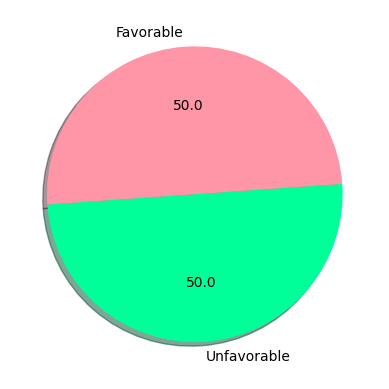

<Figure size 1600x1600 with 0 Axes>

In [145]:
labels_count = train['sentiment'].value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['Unfavorable', 'Favorable'], startangle=184, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

Equal favorable and unfavorable reviews

In [146]:
def clean_text( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 1b. Remove URLs and emoji
    review_text = re.sub(r'http\S+|www\S+', '', review_text)
    review_text = re.sub(r'[^\x00-\x7F]+', '', review_text)
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [147]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews ))                                                                  
    clean_train_reviews.append( review_to_words( train["review"][i] ))

Cleaning and parsing the training set movie reviews...


C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_3996\381688267.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review).get_text()


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000


Keras function for encoding the text. Vocab size determines how many items to encode.


In [148]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(clean_train_reviews)

In [149]:
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'movie', 'film', 'one', 'like', 'good', 'time',
       'even', 'would'], dtype='<U16')

In [150]:
vectorized = encoder(clean_train_reviews).numpy()
vectorized

array([[ 405,   71,  421, ...,    0,    0,    0],
       [ 233,  204, 3049, ...,    0,    0,    0],
       [   3,  383, 2823, ...,    0,    0,    0],
       ...,
       [ 118, 3108,   15, ...,    0,    0,    0],
       [ 638,  518,    1, ...,    0,    0,    0],
       [ 110,    2,  349, ...,    0,    0,    0]], dtype=int64)

Now I create a keras sequential model. The first layer is the encoder, which converts the text to a sequence of token indices. The next layer is the embedding layer. Is stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training, words with similar meanings often have similar vectors. The Bidirectional layer is the RNN layer. Finally, the Dense layers convert the vector to a single logit as the classification output.


In [151]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), # Use masking to handle the variable sequence lengths
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [152]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [153]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394369 (1.50 MB)
Trainable params: 39436

In [154]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00232889]


In [155]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

# same results are previous cell, showing that padding doesn't affect the model

1/1 [==============================] - 0s 99ms/step
[0.00232889]


In [156]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(.0001),
              metrics=['accuracy'])

Setting up early stopping. This will monitor the 'val_loss', and if it has not improved over the patience number of epochs, the model will step. Prevents wasting time on a poor model. restore_best_weights will restore model weights from the epoch with the best value of the monitored quantity (val_loss). 


In [157]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [158]:
history = model.fit(np.array(clean_train_reviews),
                    train['sentiment'],
                    epochs=10,
                    validation_split=.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/10
625/625 [==============================] - 87s 133ms/step - loss: 0.5426 - accuracy: 0.6643 - val_loss: 0.4331 - val_accuracy: 0.7678
Epoch 2/10
625/625 [==============================] - 101s 162ms/step - loss: 0.3070 - accuracy: 0.8717 - val_loss: 0.3172 - val_accuracy: 0.8556
Epoch 3/10
625/625 [==============================] - 132s 211ms/step - loss: 0.2389 - accuracy: 0.9054 - val_loss: 0.3008 - val_accuracy: 0.8656
Epoch 4/10
625/625 [==============================] - 133s 213ms/step - loss: 0.2071 - accuracy: 0.9198 - val_loss: 0.2937 - val_accuracy: 0.8704
Epoch 5/10
625/625 [==============================] - 133s 213ms/step - loss: 0.1866 - accuracy: 0.9287 - val_loss: 0.3126 - val_accuracy: 0.8764
Epoch 6/10
625/625 [==============================] - 134s 214ms/step - loss: 0.1690 - accuracy: 0.9388 - val_loss: 0.3266 - val_accuracy: 0.8620
Epoch 7/10
625/625 [==============================] - 137s 219ms/step - loss: 0.1565 - accuracy: 0.9427 - val_loss: 0.3491 - 

(0.0, 0.5628210119903088)

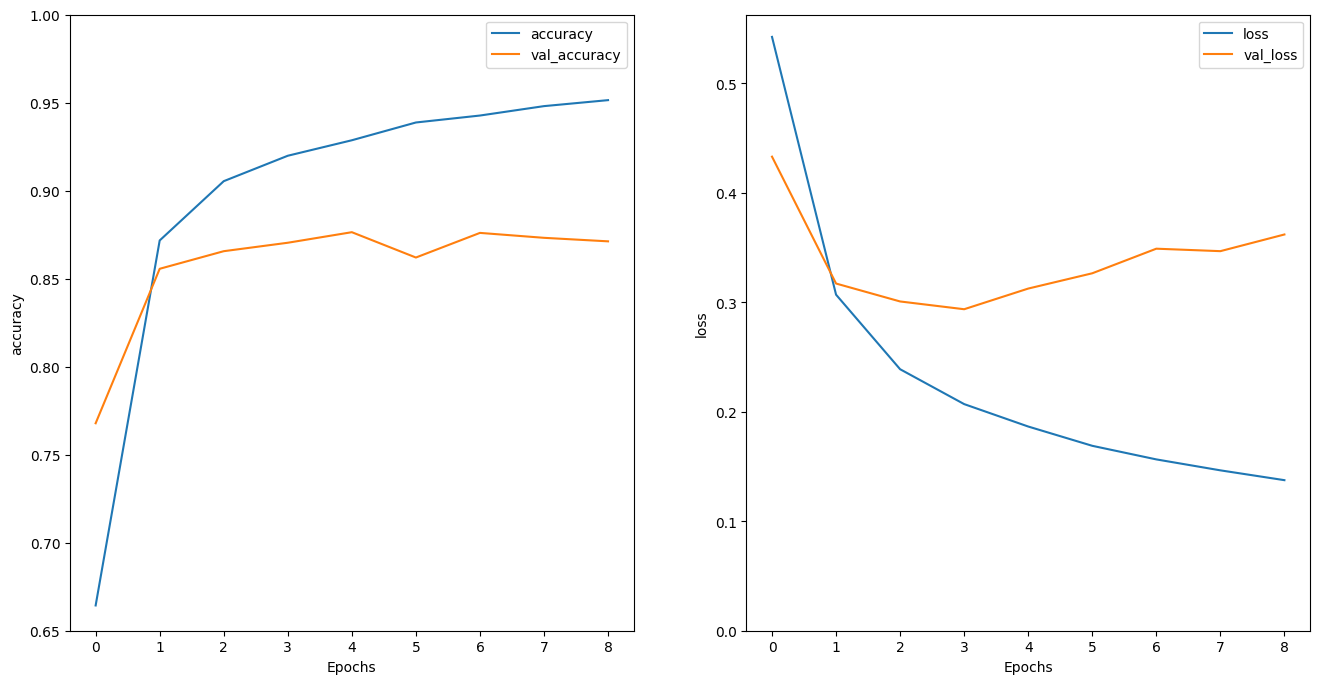

In [159]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [160]:
sample_text1 = ('Great movie')
prediction1 = model.predict(np.array([sample_text1]))
sample_text2 = ('This movie could not have been worse')
prediction2 = model.predict(np.array([sample_text2]))
sample_text3 = ('You could not pay me to watch again')
prediction3 = model.predict(np.array([sample_text3]))

print(prediction1, prediction2, prediction3)

1/1 [==============================] - 0s 12ms/step
[[0.7753756]] [[-1.0254883]] [[-0.21708046]]


Model predicts the samples well. Below zero is a negative review, above zero is positive

In [161]:
# Verify that there are 25,000 rows and 2 columns
print (test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print ("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
    if( (i+1) % 1000 == 0 ):
        print ("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

(25000, 2)
Cleaning and parsing the test set movie reviews...


C:\Users\Ryzen 5 5600X\AppData\Local\Temp\ipykernel_3996\381688267.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review).get_text()


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 25000 of 25000


In [162]:
predictions = model.predict(clean_test_reviews)
predictions = (predictions > 0.0).astype('int')

782/782 [==============================] - 82s 105ms/step


In [164]:
predictions = np.squeeze(predictions)
submission = pd.DataFrame(data={"id":test["id"], "sentiment":predictions})
submission.to_csv('RNN_clean_reviews.csv', index=False, quoting=3)

In [0]:
results.loc[-1] = ['Single LSTM', 0.87392]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results = results.reset_index(drop=True)

In [178]:
results

,model,score
0,Single LSTM,0.87392
1,Bag of Words,0.84428
2,Word2Vec - 400features,0.57236
3,Word2Vec - 150features,0.54840


In [179]:
predictions = model.predict(np.array(test.review.to_list()))
predictions = (predictions > 0.0).astype('int')

782/782 [==============================] - 152s 194ms/step


In [180]:
predictions = np.squeeze(predictions)
submission = pd.DataFrame(data={"id":test["id"], "sentiment":predictions})
submission.to_csv('RNN_test_reviews.csv', index=False, quoting=3)

In [191]:
results.loc[-1] = ['Single LSTM - Full Review', 0.85112]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results = results.reset_index(drop=True)

In [192]:
results

,model,score
0,Single LSTM,0.87392
1,LSTM Return Seq,0.86996
2,Single LSTM - Full Review,0.85112
3,Bag of Words,0.84428
4,Word2Vec - 400features,0.57236
5,Word2Vec - 150features,0.54840


Tested cleaned test reviews vs full reviews. Cleaned performed better, which makes sense because the other words aren't included in the model at all.

### Double LSTM

Adding a second LSTM layer

In [181]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [182]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [183]:
history = model.fit(np.array(clean_train_reviews),
                    train['sentiment'],
                    epochs=10,
                    validation_split=.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/10
625/625 [==============================] - 269s 416ms/step - loss: 0.5408 - accuracy: 0.6737 - val_loss: 0.3565 - val_accuracy: 0.8454
Epoch 2/10
625/625 [==============================] - 298s 476ms/step - loss: 0.3020 - accuracy: 0.8776 - val_loss: 0.3134 - val_accuracy: 0.8744
Epoch 3/10
625/625 [==============================] - 310s 496ms/step - loss: 0.2435 - accuracy: 0.9097 - val_loss: 0.3008 - val_accuracy: 0.8772
Epoch 4/10
625/625 [==============================] - 321s 514ms/step - loss: 0.2105 - accuracy: 0.9254 - val_loss: 0.3281 - val_accuracy: 0.8686
Epoch 5/10
625/625 [==============================] - 324s 519ms/step - loss: 0.1910 - accuracy: 0.9344 - val_loss: 0.3152 - val_accuracy: 0.8700
Epoch 6/10
625/625 [==============================] - 326s 522ms/step - loss: 0.1680 - accuracy: 0.9427 - val_loss: 0.3399 - val_accuracy: 0.8760
Epoch 7/10
625/625 [==============================] - 336s 538ms/step - loss: 0.1500 - accuracy: 0.9499 - val_loss: 0.3541 -

(0.0, 0.5609917961061001)

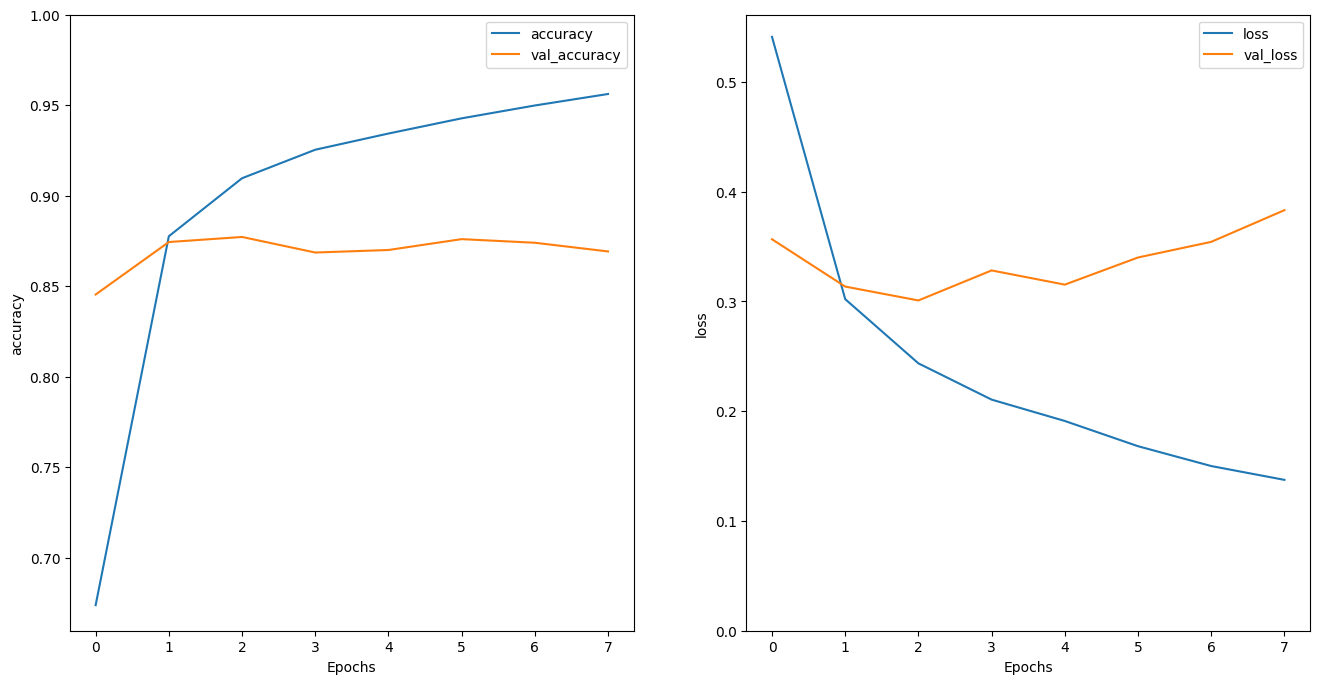

In [184]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [187]:
predictions = model.predict(clean_test_reviews)
predictions = (predictions > 0.0).astype('int')

782/782 [==============================] - 76s 98ms/step


In [188]:
predictions = np.squeeze(predictions)
submission = pd.DataFrame(data={"id": test["id"], "sentiment": predictions})
submission.to_csv('RNN_return_sequence.csv', index=False, quoting=3)

In [189]:
results.loc[-1] = ['LSTM Return Seq', 0.86996]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results = results.reset_index(drop=True)

In [193]:
results

,model,score
0,Single LSTM,0.87392
1,LSTM Return Seq,0.86996
2,Single LSTM - Full Review,0.85112
3,Bag of Words,0.84428
4,Word2Vec - 400features,0.57236
5,Word2Vec - 150features,0.54840


Second layer greatly increased the time it took for the model to train, and gave almost the same results as the single LSTM. Adding learning rate schedule to try and improve performance.

In [194]:
# This function keeps the initial learning rate for the first three epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [195]:
lr_scheduler = LearningRateScheduler(scheduler)

In [196]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [197]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [198]:
history = model.fit(np.array(clean_train_reviews),
                    train['sentiment'],
                    epochs=10,
                    validation_split=.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/10
625/625 [==============================] - 144s 223ms/step - loss: 0.5568 - accuracy: 0.6543 - val_loss: 0.3934 - val_accuracy: 0.7846 - lr: 1.0000e-04
Epoch 2/10
625/625 [==============================] - 161s 257ms/step - loss: 0.3179 - accuracy: 0.8644 - val_loss: 0.3518 - val_accuracy: 0.8434 - lr: 1.0000e-04
Epoch 3/10
625/625 [==============================] - 161s 257ms/step - loss: 0.2533 - accuracy: 0.8974 - val_loss: 0.3013 - val_accuracy: 0.8798 - lr: 1.0000e-04
Epoch 4/10
625/625 [==============================] - 167s 267ms/step - loss: 0.2154 - accuracy: 0.9184 - val_loss: 0.3028 - val_accuracy: 0.8790 - lr: 9.0484e-05
Epoch 5/10
625/625 [==============================] - 163s 260ms/step - loss: 0.1932 - accuracy: 0.9277 - val_loss: 0.3139 - val_accuracy: 0.8788 - lr: 8.1873e-05
Epoch 6/10
625/625 [==============================] - 165s 265ms/step - loss: 0.1725 - accuracy: 0.9370 - val_loss: 0.3384 - val_accuracy: 0.8756 - lr: 7.4082e-05
Epoch 7/10
625/625 [==

(0.0, 0.5772461012005806)

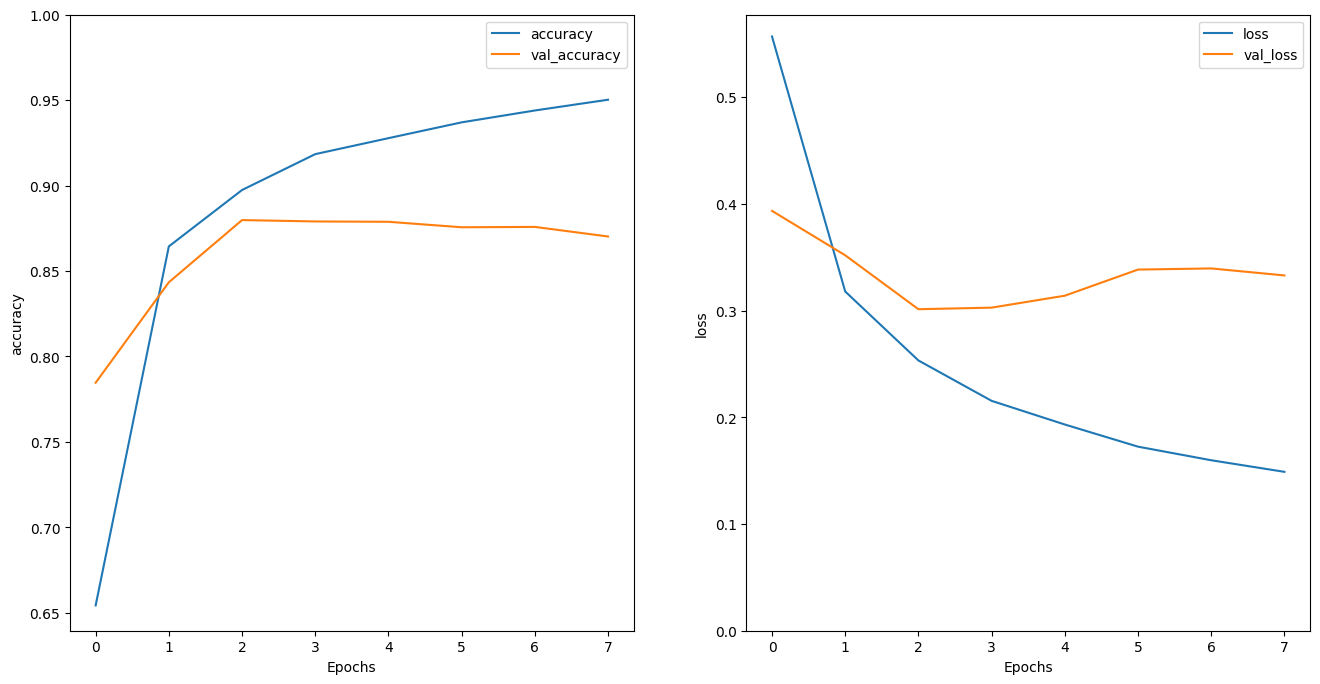

In [199]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [200]:
predictions = model.predict(clean_test_reviews)
predictions = (predictions > 0.0).astype('int')

782/782 [==============================] - 73s 92ms/step


In [201]:
predictions = np.squeeze(predictions)
submission = pd.DataFrame(data={"id": test["id"], "sentiment": predictions})
submission.to_csv('Single LSTM - LR Schedule.csv', index=False, quoting=3)

In [202]:
results.loc[-1] = ['Single LSTM - LR Schedule', 0.8776]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results = results.reset_index(drop=True)

In [203]:
results

,model,score
0,Single LSTM - LR Schedule,0.87760
1,Single LSTM,0.87392
2,LSTM Return Seq,0.86996
3,Single LSTM - Full Review,0.85112
4,Bag of Words,0.84428
5,Word2Vec - 400features,0.57236
6,Word2Vec - 150features,0.54840


LR schudling slighly improved performance. Trying a GRU inplace of LSTM.

### GRU

In [204]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [205]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [206]:
history = model.fit(np.array(clean_train_reviews),
                    train['sentiment'],
                    epochs=10,
                    validation_split=.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/10
625/625 [==============================] - 174s 264ms/step - loss: 0.6326 - accuracy: 0.5659 - val_loss: 0.3803 - val_accuracy: 0.8314 - lr: 1.0000e-04
Epoch 2/10
625/625 [==============================] - 158s 253ms/step - loss: 0.3000 - accuracy: 0.8712 - val_loss: 0.3018 - val_accuracy: 0.8730 - lr: 1.0000e-04
Epoch 3/10
625/625 [==============================] - 157s 251ms/step - loss: 0.2263 - accuracy: 0.9087 - val_loss: 0.3145 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 4/10
625/625 [==============================] - 159s 254ms/step - loss: 0.1872 - accuracy: 0.9269 - val_loss: 0.3035 - val_accuracy: 0.8712 - lr: 9.0484e-05
Epoch 5/10
625/625 [==============================] - 157s 251ms/step - loss: 0.1628 - accuracy: 0.9402 - val_loss: 0.3247 - val_accuracy: 0.8766 - lr: 8.1873e-05
Epoch 6/10
625/625 [==============================] - 157s 251ms/step - loss: 0.1413 - accuracy: 0.9512 - val_loss: 0.3475 - val_accuracy: 0.8736 - lr: 7.4082e-05
Epoch 7/10
625/625 [==

(0.0, 0.6580935783684254)

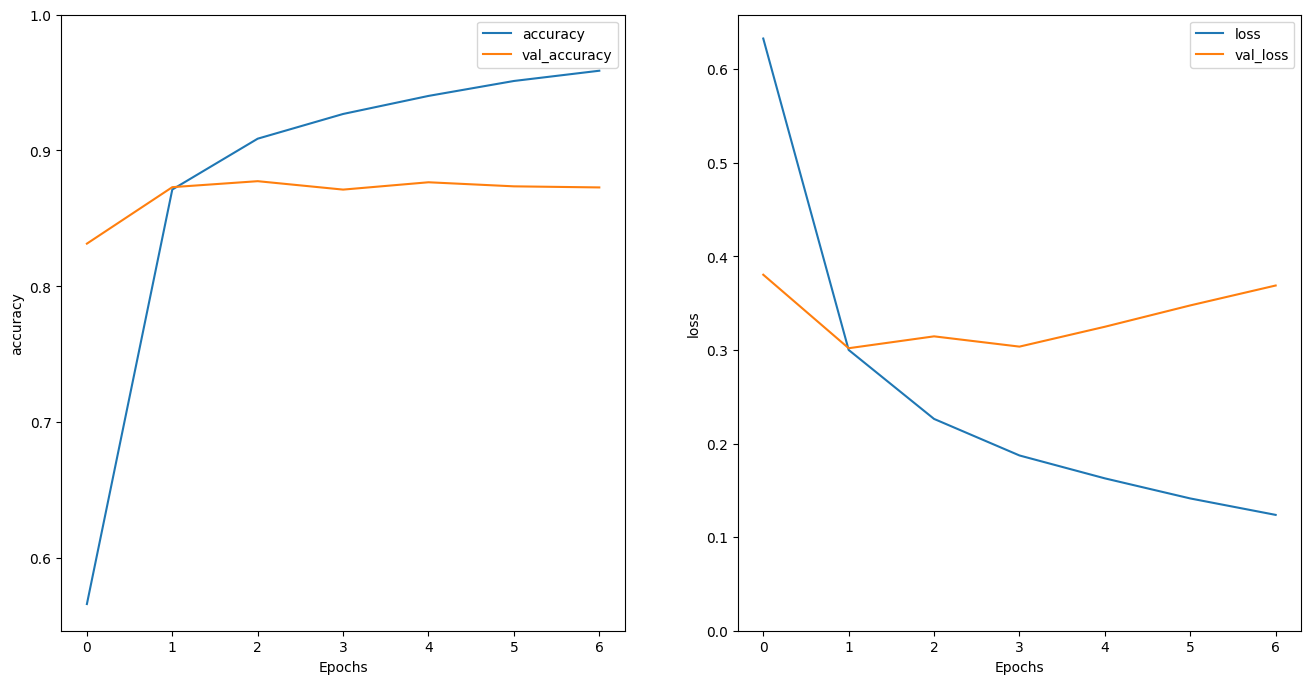

In [207]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [208]:
predictions = model.predict(clean_test_reviews)
predictions = (predictions > 0.0).astype('int')

782/782 [==============================] - 59s 73ms/step


In [209]:
predictions = np.squeeze(predictions)
submission = pd.DataFrame(data={"id": test["id"], "sentiment": predictions})
submission.to_csv('GRU.csv', index=False, quoting=3)

In [210]:
results.loc[-1] = ['GRU', 0.87392]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results = results.reset_index(drop=True)

In [211]:
results

,model,score
0,Single LSTM - LR Schedule,0.87760
1,Single LSTM,0.87392
2,GRU,0.87392
3,LSTM Return Seq,0.86996
4,Single LSTM - Full Review,0.85112
5,Bag of Words,0.84428
6,Word2Vec - 400features,0.57236
7,Word2Vec - 150features,0.54840


GRU performed similarly to LSTM. Overall both GRU and LSTM were the best models. Word2Vec didn't work well for this type of project because the sentitment is lost when word order is removed. It might work better if trained on a much larger dataset though. Other things I would be intersted in exploring would be other optimizers, like SGD on the RNNs.